# Filter Design

Reference: [Active Low-Pass Filter Design](https://www.ti.com/lit/an/sloa049d/sloa049d.pdf?ts=1681979767604)

**Second Order Filter**

\begin{align*}
H(s) &= \dfrac{\omega_0^2}{s^2 + 2\zeta \omega_0 s + \omega_0^2} \\[1em]
\end{align*}

**Quality Factor**

\begin{align*}
Q &= \dfrac{\omega_0}{2\zeta \omega_0}
\end{align*}

- A higher value of Q results in more peaking in the frequency response and more ringing in the step response

## Equivalent Noise Bandwidth

\begin{align*}
\omega_{enbw} &= \int_0^{\infty} \bigg| \dfrac{H(jw)}{H_{max}} \bigg|^2 d\omega \\[1em]
\end{align*}

**Example: RC Filter**

Transfer function of lowpass filter:
\begin{align*}
H(jw) &= \dfrac{H_{max}}{1+j\frac{\omega}{\omega_c}}
\end{align*}

Equivalent noise bandwidth
\begin{align*}
\omega_{enbw} &= \int_0^{\infty} \bigg| \dfrac{H(jw)}{H_{max}} \bigg|^2 d\omega \\[1em]
 &= \int_0^{\infty} \dfrac{1}{1+(\frac{\omega}{\omega_c})^2} d\omega \\[1em]
 &= \omega_c \tan^{-1}\dfrac{\omega}{\omega_c}\bigg|_{\ 0}^{\ \infty} \\[1em]
 &= \dfrac{\pi}{2} \omega_c \\[1em]
\end{align*}

**Thus**
\begin{align*}
\omega_{enbw} &= \dfrac{\pi}{2} \omega_{c} \\[1em]
 &= \dfrac{\pi}{2} \omega_{3dB} \\[1em]
 &= 1.57 \omega_{3dB}
 \end{align*}

## Motivation

Bandwidth of the signal is fixed by the application and sets the minimum circuit bandwidth. So how do we improve?

- Goal in designing filters is to maximize SNR and minimize the noise bandwith 
- Active filters improve SNR performance over passive filters by minimizing attenuation in the pass band and providing steeper roll-off  

## Butterworth vs Bessel vs Chebyshev

```{figure} filter-comparison.png
Filter Performance
```

In [1]:
# Imports
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

## High Pass

```{figure} SallenKeyHP.png
Sallen Key Filter: High Pass
```

\begin{align*}
W_0 &= \frac{1}{\tau \sqrt{mn}} \\[1em]
W_c &= \frac{W_0}{C_n}  \\[1em]
Q  &= \frac{\sqrt{mn}}{1+n} \\[1em]
m  &= \frac{R_1}{R_2}  \\[1em]
n  &= \frac{C_1}{C_2}  \\[1em]
\tau &= R_2 C_2
\end{align*}

In [2]:
fname = 'bessel'
fc1 = 1

In [3]:
# Future work: 
    # provide flexibility to pass m or n values
    # provide flexibility to pass capacitor or resistor values
    
def HPfilter(fname='butterworth',fc=1,nVar=2,C2Var=1e-6):
    # Determines high pass filter component values
    # Parameters: 
        # filter name, 
        # n: ratio of capacitor values (C1/C2)
        # C2: component value of C2
        
    s,m,n,C1,C2,R1,R2,Q,tau,W0 = sp.symbols('s,m,n,C1,C2,R1,R2,Q,tau,omega0')
    systemHP = sp.Matrix([
        [W0 - 1/(tau*sp.sqrt(m*n))],
        [Q - sp.sqrt(m*n)/(1+m)],
        [m - R1/R2],
        [n - C1/C2],
        [tau - R2*C2]
    ])

    Cn = 1                     # Table (Butterworth / Bessel / Chebyshev)
    Qvar = 1                   # Table (Butterworth / Bessel / Chebyshev)
    if fname == 'butterworth': 
        Cn = 1
        Qvar = 0.7071
    if fname == 'bessel': 
        Cn = 1.2736
        Qvar = 0.5773
    if fname == 'chebyshev3db':
        Cn = 0.8414
        Qvar =  1.3049   
    myVals = {
        W0:2*sp.pi*fc*Cn,
        Q:Qvar,                
        n:nVar,                # Chosen Ratio 
        C2:C2Var               # Chosen Value 
    }

    systemHP = systemHP.subs(myVals)
    eq = sp.solve(systemHP)
    return eq

In [4]:
C2Var=1e-6
eq = HPfilter(fname=fname,fc=fc1,nVar=2,C2Var=C2Var)
tau = sp.symbols('tau')
taus = []
sol = {}
if eq:
    sol = eq[0]
    if len(eq)>1:
        taus = [dct[tau] for dct in eq]
        sol = eq[taus.index(min(taus))]
eq

[{R1: 45733.3292215825,
  R2: 170730.593180212,
  m: 0.267868390601263,
  tau: 0.170730593180212,
  C1: 2.00000000000000e-6},
 {R1: 170730.593180212,
  R2: 45733.3292215825,
  m: 3.73317657135796,
  tau: 0.0457333292215825,
  C1: 2.00000000000000e-6}]

In [5]:
s,C1,C2,R1,R2 = sp.symbols('s,C1,C2,R1,R2')
f = np.logspace(-2, 4, 10000)
w = 2*np.pi*f

num = 1*s**2
a = 1
b = (1/R1)*(C1+C2)/(C1*C2)
c = 1/(R1*R2*C1*C2)
den = a*s**2 + b*s + c

components = {
    C1:sol[C1],   # Fill in from calc.
    C2:C2Var,     # Fill in from calc.
    R1:sol[R1],   # Fill in from calc.
    R2:sol[R2]    # Fill in from calc.
}
H = sp.Matrix([num/den])
H1 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]
components

{C1: 2.00000000000000e-6,
 C2: 1e-06,
 R1: 170730.593180212,
 R2: 45733.3292215825}

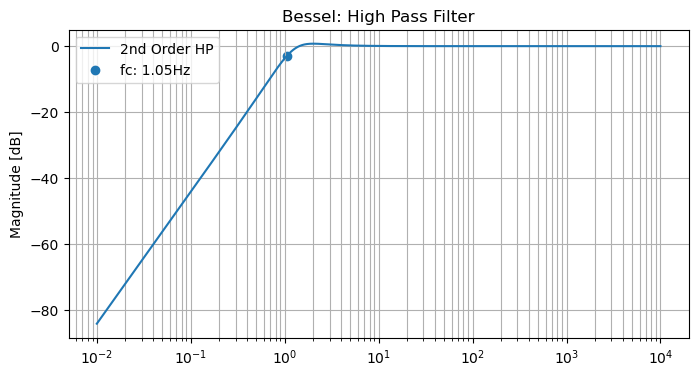

In [6]:
fig, ax = plt.subplots(figsize=(8,4))

x1 = np.where(20*np.log10(abs(H))<=-3)[0][-1]
label1 = "fc: {:.2f}Hz".format(f[x1])

ax.set_title(f'{fname.title()}: High Pass Filter')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'2nd Order HP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

```{figure} SallenKeyLP.png
Sallen Key Filter : Low Pass
```

\begin{align*}
W_0 &= \frac{1}{\tau \sqrt{mn}} \\[1em]
W_c &= \frac{W_0}{C_n}  \\[1em]
Q  &= \frac{\sqrt{mn}}{1+n} \\[1em]
m  &= \frac{R_1}{R_2}  \\[1em]
n  &= \frac{C_2}{C_1}  \\[1em]
\tau &= R_2 C_1
\end{align*}

## Low Pass

In [7]:
fname = 'bessel'
fc2 = 5e3

In [8]:
# Future work: 
    # provide flexibility to pass m or n values
    # provide flexibility to pass capacitor or resistor values
    
def LPfilter(fname='butterworth',fc=5e3,mVar=1,C2Var=1e-9):
    # Determines low pass filter component values
    # Parameters: 
        # filter name, 
        # m: ratio of capacitor values (R1/R2)
        # C2: component value of C2

    s,m,n,C1,C2,R1,R2,Q,tau,W0 = sp.symbols('s,m,n,C1,C2,R1,R2,Q,tau,omega0')
    systemLP = sp.Matrix([
        [W0 - 1/(tau*sp.sqrt(m*n))],
        [Q - sp.sqrt(m*n)/(1+m)],
        [m - R1/R2],
        [n - C2/C1],
        [tau - R2*C1]
    ])

    Cn = 1                     # Table (Butterworth / Bessel / Chebyshev)
    Qvar = 1                   # Table (Butterworth / Bessel / Chebyshev)
    if fname == 'butterworth': 
        Cn = 1
        Qvar = 0.7071
    if fname == 'bessel': 
        Cn = 1.2736
        Qvar = 0.5773
    if fname == 'chebyshev3db':
        Cn = 0.8414
        Qvar =  1.3049         
    myVals = {
        W0:2*sp.pi*fc*Cn,  
        Q:0.5773,            # Table (Butterworth / Bessel / Chebyshev)
        m:mVar,              # Chosen Ratio 
        C2:C2Var             # Chosen Value 
    }
    
    systemLP = systemLP.subs(myVals)
    eq = sp.solve(systemLP)
    return eq

In [9]:
C2Var=1e-9
eq = LPfilter(fname=fname,fc=fc2,mVar=1,C2Var=C2Var)
tau = sp.symbols('tau')
taus = []
sol = {}
if eq:
    sol = eq[0]
    if len(eq)>1:
        taus = [dct[tau] for dct in eq]
        sol = eq[taus.index(min(taus))]        
eq

[{C1: 7.50130620244903e-10,
  R1: 28856.8306051982,
  R2: 28856.8306051982,
  n: 1.33310116000000,
  tau: 2.16463922401795e-5}]

In [10]:
s,C1,C2,R1,R2 = sp.symbols('s,C1,C2,R1,R2')
f = np.logspace(-1, 5, 100000)
w = 2*np.pi*f

num = 1/(R1*R2*C1*C2)
a = 1
b = (1/C2)*(R1+R2)/(R1*R2)
c = 1/(R1*R2*C1*C2)
den = a*s**2 + b*s + c

components = {
    C1:sol[C1],     # Fill in from calc.
    C2:C2Var,       # Fill in from calc.
    R1:sol[R1],     # Fill in from calc.
    R2:sol[R2]      # Fill in from calc.
} 
H = sp.Matrix([num/den])
H2 = H = H.subs(components)
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]
components

{C1: 7.50130620244903e-10,
 C2: 1e-09,
 R1: 28856.8306051982,
 R2: 28856.8306051982}

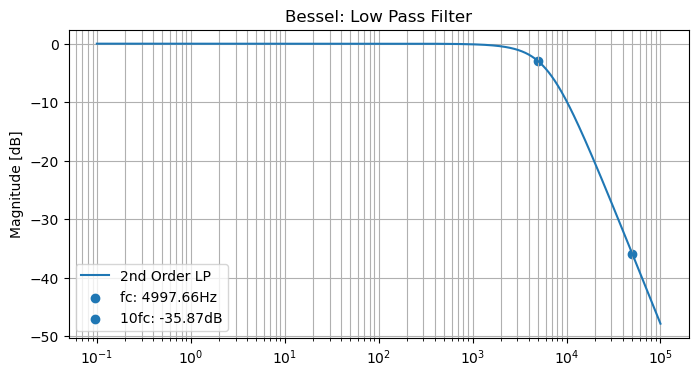

In [11]:
fig, ax = plt.subplots(figsize=(8,4))

x1 = np.where(20*np.log10(abs(H))<=-3)[0][0]
label1 = "fc: {:.2f}Hz".format(f[x1])
x2 = np.where(f>=50000)[0][0]
label2 = "{:.2f}dB".format(20*np.log10(abs(H[x2])))
label2 = f"10fc: {label2}"

ax.set_title(f'{fname.title()}: Low Pass Filter')
ax.semilogx(f, 20*np.log10(abs(H)),label=r'2nd Order LP')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.scatter(f[x2],20*np.log10(abs(H[x2])),label=label2,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

<hr>

## Band Pass

In [12]:
f = np.logspace(-1, 5, 100000)
w = 2*np.pi*f
H = H1 * H2
H = lambdify(s,H,modules='numpy')
H = H(1j*w)
H = H[0][0]

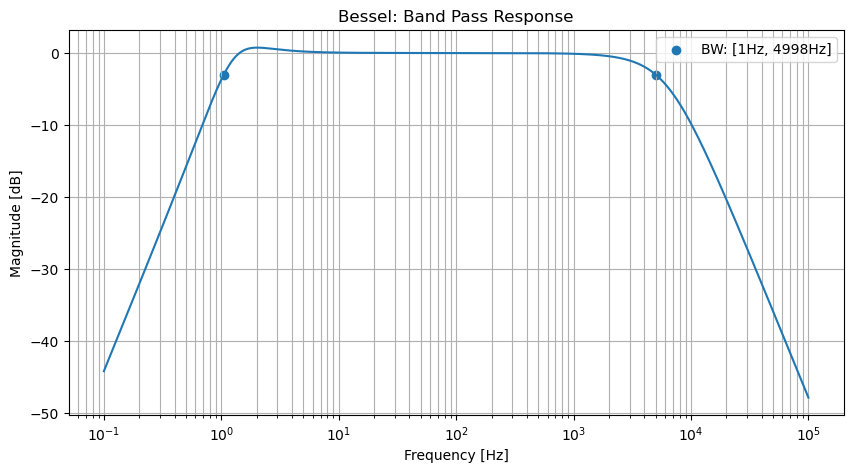

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

x0 = np.where(20*np.log10(abs(H[0:20000]))<=-3)[0][-1]
label0 = "{:.0f}Hz".format(f[x0])
x1 = 20000+np.where(20*np.log10(abs(H[20000:]))<=-3)[0][0]
label1 = "{:.0f}Hz".format(f[x1])
label1 = f"BW: [{label0}, {label1}]" 

ax.set_title(f'{fname.title()}: Band Pass Response')
ax.semilogx(f, 20*np.log10(abs(H)),color='tab:blue') # label=r'$4^{th}$ Order Sallen-Key BP')
ax.scatter(f[x0],20*np.log10(abs(H[x0])),color='tab:blue')
ax.scatter(f[x1],20*np.log10(abs(H[x1])),label=label1,color='tab:blue')
ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

## Filter Scaling Tables

```{figure} butterworth.png
Butterworth
```

```{figure} bessel.png
Bessel
```

```{figure} chebyshev-1db.png
Chebyshev 1dB
```

```{figure} chebyshev-3db.png
Chebyshev 3dB
```